![Klee - Visual Analytics](https://github.com/nikbearbrown/Visual_Analytics/blob/main/IMG/Klee_Visual_Analytics.png?raw=true)


YouTube - https://www.youtube.com/c/NikBearBrown    
GitHub - https://github.com/nikbearbrown/Visual_Analytics   
Kaggle - https://www.kaggle.com/nikbearbrown   
Klee.ai (Visual AI) - http://klee.ai 

## Predicting Ad Lift with an Ensemble of Machine Learning Algorithms

_Lessons from Kaggle – Ensemble ML and Feature Engineering_

99.9% of high ranking Kaggle submissions shared two approaches. Stacking and feature engineering. In this notebook, we will use indivdual models and stacked models to predict lift. Stacking is a type of ensemble, creating a ”super-model” by combining many complementary models.

We will use generate thousands on individual models, select the best models and combine the best models into a ”super-model” to predict lift.

_Models and hyperparamter optimization_

A model is an algorithm with a given set of hyperparamters. For example, a random forest estimator that uses 10 trees and one that uses 20 trees are two different models. Using a few algorithms and important tuning paramters (hyperparamters) we will try many combination and select rank the models on some metric like AUC, mean residual deviance, RSME as approriate for the analysis.  

_The machine learning algorithms_

We will use the following algorithms as our base:

* Deep Learning (Neural Networks)    
* Generalized Linear Model (GLM)  
* Extreme Random Forest (XRT) 
* Distributed Random Forest (DRF)     
* Gradient Boosting Machine (GBM)     
* XGBoost   


_Deep Learning (Neural Networks)_  

The are simple Multiclass perceptrons (MLPs) as discussed in the first notebook.  


_Generalized Linear Model (GLM)_   

The generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

In our case, we will assume that the the distribution of errors is normal and that the link function is the identity, which means the will will be performing simple linear regression.   Linear regression predicts the response variable $y$ assuming it has a linear relationship with predictor variable(s) $x$ or $x_1, x_2, ,,, x_n$.

$$y = \beta_0 + \beta_1 x + \varepsilon .$$


_Distributed Random Forest (DRF)_    

A Distributed Random Forest (DRF) is a powerful low-bias classification and regression tool that can fit highly non-linear data. To prevent overfitting a DRF generates a forest of classification or regression trees, rather than a single classification or regression tree through a process called bagging. The variance of estimates can be adjusted by the number of trees used. 

_Extreme Random Forest (XRT)_

Extreme random forests are nearly identical to standard random forests except that the splits, both attribute and cut-point, are chosen totally or partially at random. Bias/variance
analysis has shown that XRTs work by decreasing variance while at the same time increasing bias. Once the randomization level is properly adjusted, the variance almost vanishes while bias only slightly increases with respect to standard trees. 


_Gradient Boosting Machine (GBM)_   

Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. Boosting can create more accurate models than bagging but doesn’t help to avoid overfitting as much as bagging does.

Unlike a DRF which uses bagging to prevent overfitting a GBM uses boosting to sequentially refine a regression or classification tree. However as each tree is built in parallel it allows for multi-threading (asynchronous) training large data sets.

As with all tree based methods it creates decision trees and is highly interpretable.


_XGBoost_

XGBoost is a supervised learning algorithm that implements a process called boosting to yield accurate models. Boosting refers to the ensemble learning technique of building many models sequentially, with each new model attempting to correct for the deficiencies in the previous model. 

Both XGBoost and GBM follows the principle of gradient boosting. However, XGBoost has a more regularized model formalization to control overfitting. Boosting does not prevent overfitting the way bagging does, but typically gives better accuracy. XGBoost corrects for the deficiencies of boosting by ensembling regularized trees.

Like a GBM, each tree is built in parallel it allows for multi-threading (asynchronous) training large data sets.

As with all tree based methods it creates decision trees and is highly interpretable.

## H2O.ai Automl

H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles – one based on all previously trained models, another one on the best model of each family – will be automatically trained on collections of individual models to produce highly predictive ensemble models which, in most cases, will be the top performing models in the AutoML Leaderboard.


You will need to install H2O.ai Automl for python to run this notebook. 


```bash

pip install requests
pip install tabulate
pip install "colorama>=0.3.8"
pip install future

pip uninstall h2o


pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

```

Note: When installing H2O from pip in OS X El Capitan, users must include the --user flag.

```bash
pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o --user
```

See Downloading & Installing H2O [http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)  


In [1]:
# Import libraries
# Use pip install or conda install if missing a library
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [3]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


In [4]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:28606 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /Users/bear/.local/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpuws5ai2m
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpuws5ai2m/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpuws5ai2m/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:28606
Connecting to H2O server at http://127.0.0.1:28606 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,"14 days, 9 hours and 40 minutes"
H2O_cluster_name:,H2O_from_python_bear_xodltx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.833 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Import data and Manage Data Types

This exploration of H2O will use a version of

In [5]:
# Import the processed data from notebook One
url = "https://github.com/nikbearbrown/Visual_Analytics/raw/main/CSV/churn.csv"
df = h2o.import_file(path = url)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
df.head()

state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,no
NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,no
OH,84,area_code_408,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
MO,147,area_code_415,yes,no,0,157,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,no
LA,117,area_code_408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,no
WV,141,area_code_415,yes,yes,37,258.6,84,43.96,222,111,18.87,326.4,97,14.69,11.2,5,3.02,0,no
IN,65,area_code_415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.4,12.7,6,3.43,4,yes
RI,74,area_code_415,no,no,0,187.7,127,31.91,163.4,148,13.89,196,94,8.82,9.1,5,2.46,0,no


In [7]:
df.types

{'state': 'enum',
 'account_length': 'int',
 'area_code': 'enum',
 'international_plan': 'enum',
 'voice_mail_plan': 'enum',
 'number_vmail_messages': 'int',
 'total_day_minutes': 'real',
 'total_day_calls': 'int',
 'total_day_charge': 'real',
 'total_eve_minutes': 'real',
 'total_eve_calls': 'int',
 'total_eve_charge': 'real',
 'total_night_minutes': 'real',
 'total_night_calls': 'int',
 'total_night_charge': 'real',
 'total_intl_minutes': 'real',
 'total_intl_calls': 'int',
 'total_intl_charge': 'real',
 'number_customer_service_calls': 'int',
 'churn': 'enum'}

## Regression and Classification

H20 AutoML will automatically perform regression or classification depedending on the target data type.

If we want do regression we would need to create a numeric 0/1 version of the ``churn`` enum.


In [8]:
# Change the column type to a factor:
df['churn_bit'] = df['churn'].asnumeric()

In [9]:
df.types

{'state': 'enum',
 'account_length': 'int',
 'area_code': 'enum',
 'international_plan': 'enum',
 'voice_mail_plan': 'enum',
 'number_vmail_messages': 'int',
 'total_day_minutes': 'real',
 'total_day_calls': 'int',
 'total_day_charge': 'real',
 'total_eve_minutes': 'real',
 'total_eve_calls': 'int',
 'total_eve_charge': 'real',
 'total_night_minutes': 'real',
 'total_night_calls': 'int',
 'total_night_charge': 'real',
 'total_intl_minutes': 'real',
 'total_intl_calls': 'int',
 'total_intl_charge': 'real',
 'number_customer_service_calls': 'int',
 'churn': 'enum',
 'churn_bit': 'real'}

In [10]:
df.head()

state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,churn_bit
OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,no,0
NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,no,0
OH,84,area_code_408,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,0
OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,0
MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no,0
MO,147,area_code_415,yes,no,0,157,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,no,0
LA,117,area_code_408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,no,0
WV,141,area_code_415,yes,yes,37,258.6,84,43.96,222,111,18.87,326.4,97,14.69,11.2,5,3.02,0,no,0
IN,65,area_code_415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.4,12.7,6,3.43,4,yes,1
RI,74,area_code_415,no,no,0,187.7,127,31.91,163.4,148,13.89,196,94,8.82,9.1,5,2.46,0,no,0


In [11]:
df.describe()

Rows:4250
Cols:21




,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,churn_bit
type,enum,int,enum,enum,enum,int,real,int,real,real,int,real,real,int,real,real,int,real,int,enum,int
mins,,1.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0
mean,,100.23623529411765,,,,7.631764705882353,180.2596,99.90729411764706,30.644682352941178,200.17390588235295,100.17647058823528,17.015011764705882,200.52788235294116,99.8395294117647,9.023891764705883,10.256070588235294,4.426352941176471,2.7696541176470584,1.5590588235294118,,0.14070588235294118
maxs,,243.0,,,,52.0,351.5,165.0,59.76,359.3,170.0,30.54,395.0,175.0,17.77,20.0,20.0,5.4,9.0,,1.0
sigma,,39.698400568677286,,,,13.439882196596502,54.01237333141773,19.850817312142937,9.182096032769188,50.24951818379499,19.908591104809364,4.271211992240319,50.353548074635995,20.093219790240408,2.2659218112187327,2.7601017261885126,2.4630691127387423,0.7452041363842489,1.311433530256862,,0.34775881383359736
zeros,,0,,,,3139,2,2,2,1,1,1,1,1,1,22,22,22,886,,3652
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,OH,107.0,area_code_415,no,yes,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.7,1.0,no,0.0
1,NJ,137.0,area_code_415,no,no,0.0,243.4,114.0,41.38,121.2,110.0,10.3,162.6,104.0,7.32,12.2,5.0,3.29,0.0,no,0.0
2,OH,84.0,area_code_408,yes,no,0.0,299.4,71.0,50.9,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,no,0.0


In [12]:
df.shape

(4250, 21)

In [13]:
# Create a 80/20 train/test splie
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [14]:
print(df_train.shape)
print(df_test.shape)

(3419, 21)
(831, 21)


In [15]:
df_train.head()

state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,churn_bit
OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,no,0
OH,84,area_code_408,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,0
OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,0
MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no,0
LA,117,area_code_408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,no,0
WV,141,area_code_415,yes,yes,37,258.6,84,43.96,222,111,18.87,326.4,97,14.69,11.2,5,3.02,0,no,0
IN,65,area_code_415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.4,12.7,6,3.43,4,yes,1
RI,74,area_code_415,no,no,0,187.7,127,31.91,163.4,148,13.89,196,94,8.82,9.1,5,2.46,0,no,0
IA,168,area_code_408,no,no,0,128.8,96,21.9,104.9,71,8.92,141.1,128,6.35,11.2,2,3.02,1,no,0
MT,95,area_code_510,no,no,0,156.6,88,26.62,247.6,75,21.05,192.3,115,8.65,12.3,5,3.32,3,no,0


## Train Models Using H2O's AutoML

In [16]:
# Set the features and target
X=df.columns
print(X)

['state', 'account_length', 'area_code', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'churn', 'churn_bit']


In [17]:
# Set target and predictor variables
y ='churn'
y_numeric ='churn_bit'
X.remove(y) 
X.remove(y_numeric) 
print(X)

['state', 'account_length', 'area_code', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


## Regression

H20 AutoML will automatically perform regression or classification depedending on the target data type. 

In [18]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

## Classifying churn

In [19]:
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20220105_03824_model_26


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,45.0,45.0,58897.0,10.0,10.0,10.0,59.0,124.0,84.4




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.003661361568571558
RMSE: 0.060509185819770855
LogLoss: 0.029056397967415354
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3559983423342762: 


,,no,yes,Error,Rate
0,no,2951.0,0.0,0.0,(0.0/2951.0)
1,yes,0.0,468.0,0.0,(0.0/468.0)
2,Total,2951.0,468.0,0.0,(0.0/3419.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.355998,1.00000,191.0
1,max f2,0.355998,1.00000,191.0
2,max f0point5,0.355998,1.00000,191.0
3,max accuracy,0.355998,1.00000,191.0
4,max precision,0.990169,1.00000,0.0
5,max recall,0.355998,1.00000,191.0
6,max specificity,0.990169,1.00000,0.0
7,max absolute_mcc,0.355998,1.00000,191.0
8,max min_per_class_accuracy,0.355998,1.00000,191.0
9,max mean_per_class_accuracy,0.355998,1.00000,191.0



Gains/Lift Table: Avg response rate: 13.69 %, avg score: 13.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010237,0.983882,7.305556,7.305556,1.000000,0.986407,1.000000,0.986407,0.074786,0.074786,630.555556,630.555556,0.074786
1,2,0.020181,0.980461,7.305556,7.305556,1.000000,0.982197,1.000000,0.984333,0.072650,0.147436,630.555556,630.555556,0.147436
2,3,0.030126,0.977650,7.305556,7.305556,1.000000,0.979149,1.000000,0.982622,0.072650,0.220085,630.555556,630.555556,0.220085
3,4,0.040070,0.973802,7.305556,7.305556,1.000000,0.976000,1.000000,0.980978,0.072650,0.292735,630.555556,630.555556,0.292735
4,5,0.050015,0.967852,7.305556,7.305556,1.000000,0.971028,1.000000,0.979000,0.072650,0.365385,630.555556,630.555556,0.365385
5,6,0.100029,0.907164,7.305556,7.305556,1.000000,0.944043,1.000000,0.961521,0.365385,0.730769,630.555556,630.555556,0.730769
6,7,0.150044,0.084012,5.383041,6.664717,0.736842,0.582238,0.912281,0.835093,0.269231,1.000000,438.304094,566.471735,0.984751
7,8,0.200058,0.039344,0.000000,4.998538,0.000000,0.054034,0.684211,0.639829,0.000000,1.000000,-100.000000,399.853801,0.926804
8,9,0.300088,0.020970,0.000000,3.332359,0.000000,0.028137,0.456140,0.435931,0.000000,1.000000,-100.000000,233.235867,0.810912
9,10,0.400117,0.014731,0.000000,2.499269,0.000000,0.017440,0.342105,0.331308,0.000000,1.000000,-100.000000,149.926901,0.695019




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.04330304264565946
RMSE: 0.2080938313493686
LogLoss: 0.1733579395254538
Mean Per-Class Error: 0.1297206220113709
AUC: 0.9254978755571776
AUCPR: 0.8499976432813955
Gini: 0.8509957511143551

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2492961816029043: 


,,no,yes,Error,Rate
0,no,2879.0,72.0,0.0244,(72.0/2951.0)
1,yes,110.0,358.0,0.235,(110.0/468.0)
2,Total,2989.0,430.0,0.0532,(182.0/3419.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249296,0.797327,207.0
1,max f2,0.125895,0.799582,249.0
2,max f0point5,0.607186,0.872159,139.0
3,max accuracy,0.485882,0.948815,157.0
4,max precision,0.996583,1.000000,0.0
5,max recall,0.002573,1.000000,395.0
6,max specificity,0.996583,1.000000,0.0
7,max absolute_mcc,0.435833,0.768764,166.0
8,max min_per_class_accuracy,0.047143,0.867521,304.0
9,max mean_per_class_accuracy,0.125895,0.885467,249.0



Gains/Lift Table: Avg response rate: 13.69 %, avg score: 11.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010237,0.975436,7.305556,7.305556,1.000000,0.983312,1.000000,0.983312,0.074786,0.074786,630.555556,630.555556,0.074786
1,2,0.020181,0.963178,7.305556,7.305556,1.000000,0.969081,1.000000,0.976300,0.072650,0.147436,630.555556,630.555556,0.147436
2,3,0.030126,0.942992,7.305556,7.305556,1.000000,0.952745,1.000000,0.968524,0.072650,0.220085,630.555556,630.555556,0.220085
3,4,0.040070,0.920591,7.305556,7.305556,1.000000,0.931625,1.000000,0.959367,0.072650,0.292735,630.555556,630.555556,0.292735
4,5,0.050015,0.893183,7.305556,7.305556,1.000000,0.906841,1.000000,0.948923,0.072650,0.365385,630.555556,630.555556,0.365385
5,6,0.100029,0.506874,6.194769,6.750162,0.847953,0.746998,0.923977,0.847961,0.309829,0.675214,519.476933,575.016244,0.666403
6,7,0.150044,0.130898,2.776966,5.425763,0.380117,0.277130,0.742690,0.657684,0.138889,0.814103,177.696556,442.576348,0.769372
7,8,0.200058,0.063007,0.683561,4.240213,0.093567,0.090997,0.580409,0.516012,0.034188,0.848291,-31.643925,324.021280,0.751035
8,9,0.300088,0.029037,0.341780,2.940735,0.046784,0.041869,0.402534,0.357964,0.034188,0.882479,-65.821962,194.073533,0.674752
9,10,0.400117,0.018503,0.234974,2.264295,0.032164,0.023230,0.309942,0.274281,0.023504,0.905983,-76.502599,126.429500,0.586091




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.953492,0.010530,0.954678,0.966374,0.960526,0.941520,0.944363
1,auc,0.923917,0.019115,0.922265,0.950798,0.933925,0.909066,0.903532
2,err,0.046507,0.010530,0.045322,0.033626,0.039474,0.058480,0.055637
3,err_count,31.800000,7.190271,31.000000,23.000000,27.000000,40.000000,38.000000
4,f0point5,0.864343,0.030513,0.864486,0.892421,0.884956,0.814249,0.865604
5,f1,0.813790,0.037316,0.826816,0.863905,0.816327,0.761905,0.800000
6,f2,0.769309,0.046857,0.792291,0.837156,0.757576,0.715884,0.743640
7,lift_top_group,7.357875,0.687639,7.125000,7.685393,8.240964,7.354839,6.383178
8,logloss,0.176695,0.039174,0.173171,0.133074,0.147749,0.199081,0.230400
9,max_per_class_error,0.257520,0.052958,0.229167,0.179775,0.277108,0.311828,0.289720



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-01-05 00:41:17,50.283 sec,0.0,0.343723,0.399263,0.500000,0.136882,1.000000,0.863118
1,,2022-01-05 00:41:17,50.313 sec,5.0,0.246634,0.226988,0.990754,0.959525,7.305556,0.025739
2,,2022-01-05 00:41:17,50.348 sec,10.0,0.191903,0.158972,0.994693,0.974579,7.305556,0.020766
3,,2022-01-05 00:41:17,50.386 sec,15.0,0.157797,0.118139,0.997588,0.986787,7.305556,0.016379
4,,2022-01-05 00:41:18,50.422 sec,20.0,0.133233,0.089990,0.999154,0.994913,7.305556,0.011992
5,,2022-01-05 00:41:18,50.457 sec,25.0,0.115171,0.070986,0.999716,0.998240,7.305556,0.006435
6,,2022-01-05 00:41:18,50.491 sec,30.0,0.101075,0.057479,0.999940,0.999629,7.305556,0.002340
7,,2022-01-05 00:41:18,50.527 sec,35.0,0.086799,0.045957,0.999995,0.999968,7.305556,0.000292
8,,2022-01-05 00:41:18,50.563 sec,40.0,0.072949,0.036634,1.000000,1.000000,7.305556,0.000000
9,,2022-01-05 00:41:18,50.600 sec,45.0,0.060509,0.029056,1.000000,1.000000,7.305556,0.000000



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,state,294.071503,1.000000,0.168778
1,total_day_minutes,259.016449,0.880794,0.148659
2,total_day_charge,251.851196,0.856428,0.144546
3,number_customer_service_calls,218.058838,0.741516,0.125152
4,international_plan,177.808136,0.604643,0.102050
5,total_eve_charge,103.096588,0.350583,0.059171
6,total_intl_calls,80.924599,0.275187,0.046445
7,total_intl_charge,69.742538,0.237162,0.040028
8,number_vmail_messages,66.796326,0.227143,0.038337
9,total_eve_minutes,65.303848,0.222068,0.037480


In [20]:
print(aml.leaderboard)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20220105_03824_model_26,0.925498,0.173358,0.849998,0.129721,0.208094,0.043303
StackedEnsemble_BestOfFamily_4_AutoML_1_20220105_03824,0.924991,0.1567,0.868018,0.125028,0.194377,0.0377824
GBM_grid_1_AutoML_1_20220105_03824_model_23,0.92348,0.177346,0.844619,0.130215,0.209977,0.0440901
GBM_grid_1_AutoML_1_20220105_03824_model_13,0.923399,0.204694,0.844573,0.14207,0.230336,0.0530548
GBM_grid_1_AutoML_1_20220105_03824_model_9,0.921475,0.16695,0.856795,0.121225,0.20393,0.0415875
GBM_grid_1_AutoML_1_20220105_03824_model_22,0.921197,0.197739,0.820928,0.14103,0.231443,0.0535661
GBM_grid_1_AutoML_1_20220105_03824_model_24,0.920476,0.173763,0.85506,0.141341,0.208878,0.0436302
XGBoost_grid_1_AutoML_1_20220105_03824_model_16,0.919887,0.171639,0.860848,0.12452,0.20413,0.0416689
GBM_grid_1_AutoML_1_20220105_03824_model_3,0.919833,0.181753,0.841382,0.13045,0.216021,0.0466652
StackedEnsemble_AllModels_3_AutoML_1_20220105_03824,0.919609,0.147157,0.876752,0.0920404,0.185277,0.0343274


## Regressing on churn_bit

In [22]:
aml.train(x=X,y=y_numeric,training_frame=df_train) 

AutoML progress: |
00:44:16.357: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

█
00:44:18.366: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.


00:44:19.372: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

██
00:44:21.379: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before tr

In [23]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_3_AutoML_2_20220105_04416,0.0383542,0.195842,0.0383542,0.0920803,0.138994
StackedEnsemble_BestOfFamily_4_AutoML_2_20220105_04416,0.0392754,0.19818,0.0392754,0.0941025,0.140552
StackedEnsemble_AllModels_2_AutoML_2_20220105_04416,0.0399959,0.19999,0.0399959,0.0942727,0.141837
StackedEnsemble_BestOfFamily_3_AutoML_2_20220105_04416,0.0404572,0.20114,0.0404572,0.0934053,0.142265
XGBoost_grid_1_AutoML_2_20220105_04416_model_38,0.0409389,0.202334,0.0409389,0.097028,0.144218
StackedEnsemble_AllModels_1_AutoML_2_20220105_04416,0.0412702,0.203151,0.0412702,0.0991881,0.14482
XGBoost_grid_1_AutoML_2_20220105_04416_model_39,0.0417265,0.204271,0.0417265,0.0947812,0.145345
XGBoost_grid_1_AutoML_2_20220105_04416_model_2,0.0418864,0.204662,0.0418864,0.104085,0.146767
XGBoost_grid_1_AutoML_2_20220105_04416_model_42,0.0418867,0.204662,0.0418867,0.100054,0.146093
XGBoost_grid_1_AutoML_2_20220105_04416_model_18,0.042,0.204939,0.042,0.101993,0.147233


## RSME comparison and understanding the leader board

The best models after running for a little under four minutes is around 0.005 about half of that of the 0.010 RSME that we got our simple MLP in notebook one and a quarter of the  0.017 RSME that we got with a simple MLP with the same independent variables. 

When we run for a short time, under 10 minutes, out leaderboard with be biased towards trre-based methods as the deep learners take much more time to converge.  It is rare to see deep learners in the top 500 models when we run for less than 5 moinutes.

We should still plot the results but before we do that let's discuss a big advantage of these models, model interpretability.


In [24]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'StackedEnsemble_AllModels_3_AutoML_2_20220105_04416': 0,
 'StackedEnsemble_BestOfFamily_4_AutoML_2_20220105_04416': 1,
 'StackedEnsemble_AllModels_2_AutoML_2_20220105_04416': 2,
 'StackedEnsemble_BestOfFamily_3_AutoML_2_20220105_04416': 3,
 'XGBoost_grid_1_AutoML_2_20220105_04416_model_38': 4,
 'GLM_1_AutoML_2_20220105_04416': 116}

## Examine the Best Model

In [25]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

4


In [26]:
best_model.algo

'xgboost'

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

## Variable importance plot

Variable importance plots in tree-based methods provides a list of the most significant variables in descending order by a measure of the information in each variable. Remember that tree calculates the information content of each variable. A variable importance plot is just a bar chart of each variables information content in decreasing order.

It can show actual information estimates or standardized plots like the one below. In a standardized plot the most important variable is always given a value of 1.0. The other variables scores represent their percentage of information relative to the most important variable.

Notice that some varibales have almost no information content. Knowing this allows for feature selection by removing unimportant variables. This makes a model more effecient to run and helps prevent overfitting as the unimportant variables can fit noise and, as we saw in notebook one, make strange predictions.



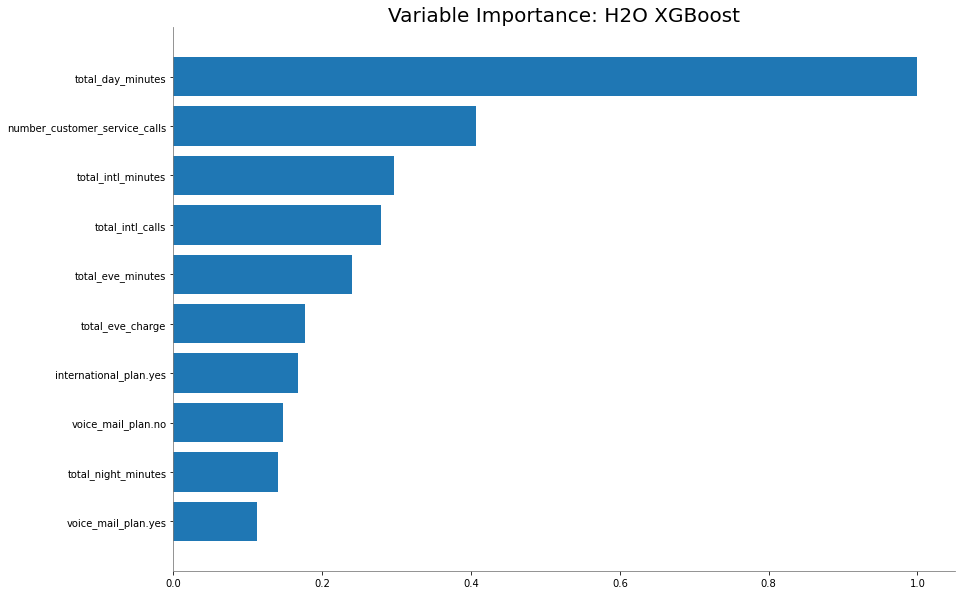

<Figure size 432x288 with 0 Axes>

In [28]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/ipykernel_6239/4076042168.py:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


116
glm


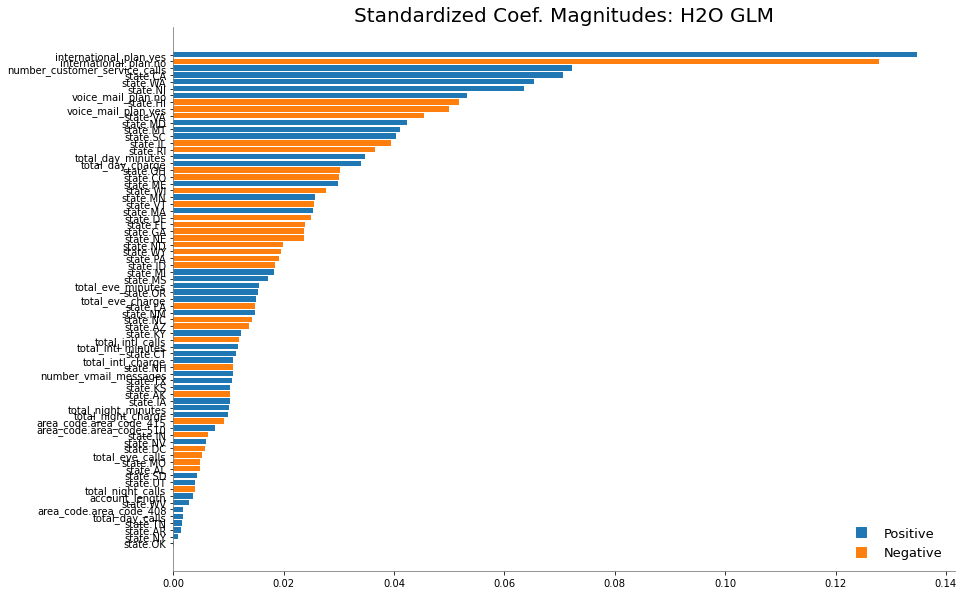

In [29]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [30]:
print(best_model.rmse(train = True))

0.06936940104289561


In [31]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [32]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.041619190292098845,
 'rmse': 0.2040078191935271,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [33]:
predictions = best_model.predict(df_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [34]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,-0.054734
1,0.010654
2,-0.016814
3,-0.028903
4,0.027924


In [35]:
y_test=h2o.as_list(df_test[y_numeric])
y_test[0:5]

,churn_bit
0,0
1,0
2,0
3,0
4,0


## Partial Dependence Plots

Partial dependence plots (PDP) show the dependence between the target response and a set of features, marginalizing over the values of all other features. Intuitively, we can interpret the partial dependence as the expected target response as a function of the feature.

The partial dependence plot gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. This helps one answer the question of how changing a variables values would change the outcome.

The partial dependence plots show only impact of single variable if others are kept constant. But in many cases, there is interaction between variables. Never-the-less, they are very useful in estimating whether, for example, doubling some predictor varible will double a response or whether that predictor varible is already saturated.  



In [36]:
print(X)

['state', 'account_length', 'area_code', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_day_minutes'.


,total_day_minutes,mean_response,stddev_response,std_error_mean_response
0,0.0,0.153162,0.213807,0.003280
1,18.5,0.125091,0.276013,0.004234
2,37.0,0.125091,0.276013,0.004234
3,55.5,0.125091,0.276013,0.004234
4,74.0,0.125091,0.276013,0.004234
5,92.5,0.123300,0.275981,0.004233
6,111.0,0.126429,0.276343,0.004239
7,129.5,0.119816,0.277017,0.004249
8,148.0,0.107345,0.261503,0.004011
9,166.5,0.078516,0.217936,0.003343


[]

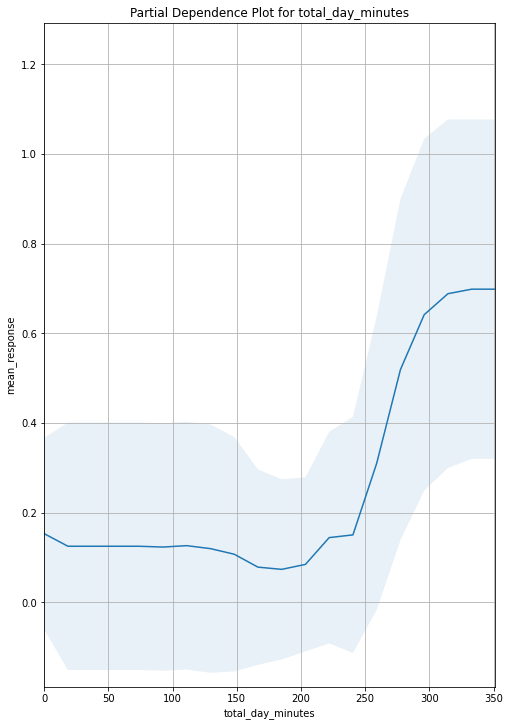

In [37]:
best_model.partial_plot(df, cols=['total_day_minutes'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_night_minutes'.


,total_night_minutes,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.145492,0.292157,0.004481
1,20.789474,0.155559,0.273375,0.004193
2,41.578947,0.155559,0.273375,0.004193
3,62.368421,0.155559,0.273375,0.004193
4,83.157895,0.146292,0.275862,0.004232
5,103.947368,0.139571,0.278033,0.004265
6,124.736842,0.128394,0.281864,0.004324
7,145.526316,0.138995,0.291898,0.004478
8,166.315789,0.132286,0.294610,0.004519
9,187.105263,0.132010,0.299338,0.004592



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_night_calls'.


,total_night_calls,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.150574,0.301262,0.004621
1,9.210526,0.145746,0.300862,0.004615
2,18.421053,0.145746,0.300862,0.004615
3,27.631579,0.145746,0.300862,0.004615
4,36.842105,0.145746,0.300862,0.004615
5,46.052632,0.145746,0.300862,0.004615
6,55.263158,0.145746,0.300862,0.004615
7,64.473684,0.146469,0.304787,0.004675
8,73.684211,0.140882,0.304604,0.004672
9,82.894737,0.144011,0.303371,0.004653



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_night_charge'.


,total_night_charge,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.148855,0.308347,0.004730
1,0.935263,0.129909,0.296866,0.004554
2,1.870526,0.129909,0.296866,0.004554
3,2.805789,0.129909,0.296866,0.004554
4,3.741053,0.129909,0.296866,0.004554
5,4.676316,0.128446,0.296547,0.004549
6,5.611579,0.134405,0.300846,0.004615
7,6.546842,0.134469,0.301226,0.004621
8,7.482105,0.136227,0.303389,0.004654
9,8.417368,0.140720,0.312751,0.004797



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_intl_minutes'.


,total_intl_minutes,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.153131,0.322031,0.004940
1,1.052632,0.122645,0.269367,0.004132
2,2.105263,0.122645,0.269367,0.004132
3,3.157895,0.122627,0.269373,0.004132
4,4.210526,0.126221,0.270846,0.004155
5,5.263158,0.148876,0.274467,0.004210
6,6.315789,0.125597,0.276151,0.004236
7,7.368421,0.127232,0.285701,0.004382
8,8.421053,0.126895,0.291440,0.004470
9,9.473684,0.126380,0.291530,0.004472



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_intl_calls'.


,total_intl_calls,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.111660,0.283546,0.004349
1,1.052632,0.209079,0.355043,0.005446
2,2.105263,0.202500,0.356481,0.005468
3,3.157895,0.119923,0.288878,0.004431
4,4.210526,0.121502,0.290763,0.004460
5,5.263158,0.126923,0.291407,0.004470
6,6.315789,0.126766,0.290208,0.004452
7,7.368421,0.117001,0.286729,0.004398
8,8.421053,0.113284,0.287555,0.004411
9,9.473684,0.115109,0.287522,0.004410



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'total_intl_charge'.


,total_intl_charge,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.140562,0.304946,0.004678
1,0.284211,0.136506,0.304033,0.004664
2,0.568421,0.136506,0.304033,0.004664
3,0.852632,0.136506,0.304033,0.004664
4,1.136842,0.136506,0.304033,0.004664
5,1.421053,0.138476,0.304981,0.004678
6,1.705263,0.138505,0.305241,0.004682
7,1.989474,0.135278,0.307354,0.004715
8,2.273684,0.136394,0.307468,0.004716
9,2.557895,0.138427,0.307451,0.004716



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_2_20220105_04416_model_38 on column 'number_customer_service_calls'.


,number_customer_service_calls,mean_response,stddev_response,std_error_mean_response
0,0.0,0.103336,0.274623,0.004213
1,1.0,0.112095,0.275230,0.004222
2,2.0,0.109374,0.276090,0.004235
3,3.0,0.112979,0.275245,0.004222
4,4.0,0.466441,0.398941,0.006119
5,5.0,0.517436,0.366782,0.005626
6,6.0,0.519288,0.366584,0.005623
7,7.0,0.516813,0.367450,0.005636
8,8.0,0.516813,0.367450,0.005636
9,9.0,0.517334,0.367249,0.005633


[, , , , , , ]

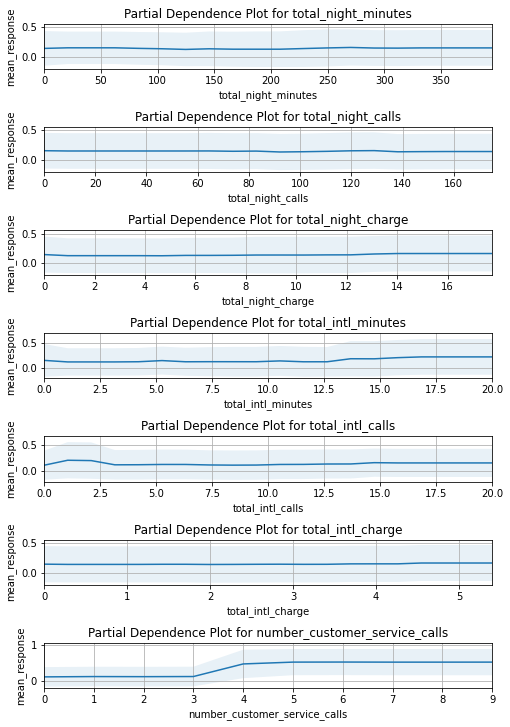

In [38]:
best_model.partial_plot(df, cols=['total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls'])

## Shutdown H2O Cluster

In [39]:
h2o.cluster().shutdown()

H2O session _sid_840b closed.


###  Appendix - Generalized Linear Model (GLM)  

The generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

Generalized Linear Models (GLM) estimate regression models for various probability distributions. In addition to the Gaussian (i.e. normal) distribution, these include Poisson, binomial, and gamma distributions. This can be used either for prediction or classification.

Overfitting is prevented using L1, L2 and elastic-net regularization.

While not easily parallelable, maximum likelihood estimates of coefficients is very efficient.

GLMs are highly interpretable as the coefficients (i.e. the slopes) as they directly related the degree the dependent variable changes in response to a change in each independent variable.

For these data and the regression case, we can think of this as linear regression. to 
In linear regression, the use of the least-squares estimator is justified by the Gauss--Markov theorem, which does not assume that the distribution is normal. From the perspective of generalized linear models, however, it is useful to suppose that the distribution function is the normal distribution with constant variance and the link function is the identity, which is
the canonical link if the variance is known.

In our case, we will assume that the the distribution of errors is normal and that the link function is the identity, which means the will will be performing simple linear regression.   Linear regression predicts the response variable $y$ assuming it has a linear relationship with predictor variable(s) $x$ or $x_1, x_2, ,,, x_n$.

$$y = \beta_0 + \beta_1 x + \varepsilon .$$

*Simple* regression use only one predictor variable $x$. *Mulitple* regression uses a set of predictor variables $x_1, x_2, ,,, x_n$.

The *response variable* $y$ is also called the regressand, forecast, dependent or explained variable. The *predictor variable* $x$ is also called the regressor, independent or explanatory variable.

The parameters $\beta_0$ and $\beta_1$ determine the intercept and the slope of the line respectively. The intercept $\beta_0$ represents the predicted value of $y$ when $x=0$. The slope $\beta_1$ represents the predicted increase in $Y$ resulting from a one unit increase in $x$.

Note that the regression equation is just our famliar equation for a line with an error term.

The equation for a line:  
$$ Y = bX + a $$

$$y = \beta_0 + \beta_1 x $$

The equation for a line with an error term:  

$$ Y = bX + a + \varepsilon $$

$$y = \beta_0 + \beta_1 x + \varepsilon .$$

- $b$ = $\beta_1$ = slope
- $a$ = $\beta_0$ = $Y$ intercept
- $\varepsilon$ = error term


We can think of each observation $y_i$ consisting of the systematic or explained part of the model, $\beta_0+\beta_1x_i$, and the random *error*, $\varepsilon_i$.

_Zero Slope_

Note that when  $\beta_1 = 0$ then response does not change as the predictor changes.

For multiple regression $x$ is a $X$ to produce a system of equations:  

$$ Y = \beta_0 + \beta_1 X  + \varepsilon $$

_The error $\varepsilon_i$_

The error term is a catch-all for anything that may affect $y_i$ other than $x_i$. We assume that these errors:

* have mean zero; otherwise the forecasts will be systematically biased.
* statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data).
* homoscedasticity (constant variance) of the errors.
* normality of the error distribution.

If any of these assumptions is violated then the robustness of the model to be taken with a grain of salt.


_Least squares estimation_

In a linear model, the values of $\beta_0$ and $\beta_1$. These need to be estimated from the data. We call this *fitting a model*.

The least squares method iis the most common way of estimating $\beta_0$ and $\beta_1$ by minimizing the sum of the squared errors. The values of $\beta_0$ and $\beta_1$ are chosen so that that minimize

$$\sum_{i=1}^N \varepsilon_i^2 = \sum_{i=1}^N (y_i - \beta_0 - \beta_1x_i)^2. $$


Using mathematical calculus, it can be shown that the resulting **least squares estimators** are

$$\hat{\beta}_1=\frac{ \sum_{i=1}^{N}(y_i-\bar{y})(x_i-\bar{x})}{\sum_{i=1}^{N}(x_i-\bar{x})^2} $$ 

and

$$\hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x}, $$

where $\bar{x}$ is the average of the $x$ observations and $\bar{y}$ is the average of the $y$ observations. The estimated line is known as the *regression line*.

To solve least squares with gradient descent or stochastic gradient descent (SGD) or losed Form (set derivatives equal to zero and solve for parameters).

_Fitted values and residuals_

The response values of $y$ obtained from the observed $x$ values are
called *fitted values*: $\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1x_i$, for
$i=1,\dots,N$. Each $\hat{y}_i$ is the point on the regression
line corresponding to $x_i$.

The difference between the observed $y$ values and the corresponding fitted values are the *residuals*:

$$e_i = y_i - \hat{y}_i = y_i -\hat{\beta}_0-\hat{\beta}_1x_i. $$

The residuals have some useful properties including the following two:

$$\sum_{i=1}^{N}{e_i}=0 \quad\text{and}\quad \sum_{i=1}^{N}{x_ie_i}=0. $$

Residuals are the errors that we cannot predict.Residuals are highly useful for studying whether a given regression model is an appropriate statistical technique for analyzing the relationship.


###  Appendix - _Decision-tree based methods (DRF, XRT, GBM, and XGBoost)_


**What is a decision-tree?**

What is a tree?  In mathematics, and more specifically in graph theory, a [tree](https://en.wikipedia.org/wiki/Tree_(graph_theory)) is a directed or an undirected graph in which any two vertices are connected by exactly one path. In other words, any acyclic connected graph is a tree.

A tree is an undirected graph G that satisfies any of the following equivalent conditions:  
* G is connected and has no cycles.   
* G is acyclic, and a simple cycle is formed if any edge is added to G.  
* G is connected, but is not connected if any single edge is removed from G.  

A rooted tree is a tree in which one vertex/node has been designated the root. The edges of a rooted tree can be assigned a natural orientation, either away from or towards the root, in which case the structure becomes a directed rooted tree. 

A vertex/node that does not split is called Leaf or Terminal node.     

A sub section of entire tree is called branch or sub-tree.  

A vertex/node, which is divided into sub-nodes is called parent node of sub-nodes where as sub-nodes are the child of parent node.  

A [decision tree](https://en.wikipedia.org/wiki/Decision_tree) is a [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) algorithm that uses a tree-like graph or model of decisions and their outcomes.  The decision tree can be linearized into decision rules, where the outcome is the contents of the leaf node, and the conditions along the path form a conjunction in the if clause. In general, the rules have the form:

$if \quad condition1 \quad and \quad condition2 \quad and \quad condition3 \quad then \quad outcome$

Each node in the tree is a decisions/tests. Each path from the tree root to a leaf corresponds to a conjunction of attribute decisions/tests. The tree itself corresponds to a disjunction of these conjunctions.

**The 20 Questions of machine learning**  

In the traditional [20 Questions](https://en.wikipedia.org/wiki/Twenty_Questions) game, one player is chosen to be the answerer. That person chooses a subject (object) but does not reveal this to the others. All other players are questioners. They each take turns asking a question which can be answered with a simple "Yes" or "No." The questioners try to guess the answerers subject (object).

The Two Rules 

  Rule 1: Questioners ask Yes-or-No questions     
  Rule 2: Answerer responds with a Yes or a No    

Traditionally,first question is something like the following: 

  * "Is it animal?"  
  * "Is it vegetable?"  
  * "Is it mineral?"  
  
Suppose the answer is "Justin Bieber?"

Which would be a better first question?

"Is it Taylor Swift?" or "Is it animal?"   

**Estimating the information in a data split?**

Like 20 questions we want to split data in such a way as to maximize the information generated from the split.

To calculate entropy, we can calculate the information difference, $-p_1 \log p_1 - p_2 \log p_2$. Generalizing this to n events, we get:

$$
entropy(p_1, p_2, ... p_n) = -p_1 \log p_1 - p_2 \log p_2 ...  - p_n \log p_n 
$$

which is just the Shannon entropy

$$
H_1 (X) = - \sum_{i=1}^n p_i \log p_i. 
$$

For example, if entropy = $-1.0 \log (1.0) - 0.0 \log (0.0) = 0$ then this provides no information. If entropy = $-0.5 \log (0.5) - 0.5 \log (0.5) = 1.0$ then this provides one “bit” of information.  Note that when $P(X)$ is 0.5 one is most uncertain and the Shannon entropy is highest (i.e. 1). When $P(X)$ is either 0.0 or 1.0 one is most certain and the Shannon entropy is lowest (i.e. 0)

_Shannon entropy_  

The notion of using entropy as a measure of change in system state and dynamics comes both from [statistical physics](https://en.wikipedia.org/wiki/Entropy) and from [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In statistical physics, entropy is a measure of disorder and uncertainty in a random variable; the higher the entropy, the greater the disorder. In the statistical physics context, the term usually refers to [Gibbs entropy](https://en.wikipedia.org/wiki/Entropy_(statistical_thermodynamics)), which measures the macroscopic state of the system as defined by a distribution of atoms and molecules in a thermodynamic system. Gibbs entropy is a measure of the disorder in the arrangements of its particles. As the position of a particle becomes less predictable, the entropy increases. For a classical system (i.e., a collection of classical particles) with a discrete set of microstates, if $E_i$ is the energy of microstate $i$, and $p_i$ is the probability that it occurs during the system's fluctuations, then the entropy of the system is

$$
S = -k_\text{B}\,\sum_i p_i \ln \,p_i
$$

The quantity $k_\text{B}$ is a physical constant known as [Boltzmann's constant](https://en.wikipedia.org/wiki/Boltzmann_constant), which, like the entropy, has units of heat capacity. The logarithm is dimensionless.

In information theory, entropy is also a measure of the uncertainty in a random variable. In this context, however, the term usually refers to the [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)), which quantifies the expected value of the information contained in a message (or the expected value of the information of the probability distribution). The concept was introduced by [Claude E. Shannon](https://en.wikipedia.org/wiki/Claude_Shannon) in his 1948 paper "A Mathematical Theory of Communication." Shannon entropy establishes the limits to possible data compression and channel capacity.  That is, the entropy gives a lower bound for the efficiency of an encoding scheme (in other words, a lower bound on the possible compression of a data stream). Typically this is expressed in the number of ‘bits’ or ‘nats’ that are required to encode a given message. Given the probability of each of n events, the information required to predict an event is the distribution’s entropy. 

Low entropy means the system is very ordered, that is, very predictable. High entropy means the system is mixed, that is, very unpredictable; a lot of information is needed for prediction. 

The Shannon entropy can explicitly be written as

$$
E(X) = \sum_{i} {\mathrm{P}(x_i)\,\mathrm{I}(x_i)} = -\sum_{i} {\mathrm{P}(x_i) \log_b \mathrm{P}(x_i)},
$$

where b is the base of the logarithm used. Common values of b are 2, Euler's number $e$, and 10, and the unit of entropy is shannon for b = 2, nat for b = e, and hartley for b = 10.When b = 2, the units of entropy are also commonly referred to as bits.

The Shannon entropy is by far the most common information-theoretic measure there are others. Other information-theoretic measures include: plog,Rényi entropy, Hartley entropy, collision entropy, min-entropy, Kullback-Leibler divergence and the information dimension.

The Shannon entropy is the Rényi entropy with an alpha of one (see appendix). The Shannon entropy is a simple estimate of the expected value of the information contained in a message. It assumes independence and identically distributed random variables, which is a simplification when applied to word counts. In this sense it is analogous to naïve Bayes, in that it is very commonly used and thought to work well in spite of violating some assumptions upon which it is based.

The limiting value of $H_\alpha as \alpha \rightarrow 1$ is the Shannon entropy:

$$
H_1(X) = - \sum_{i=1}^n p_i \log p_i. 
$$

**Classification vs Regression Trees**  

Types of decision tree is based on the type of target variable we have. It can be of two types:

Classification Tree (Categorical Response Variable Decision Tree): Decision Tree which separates the dataset into classes belonging to the categorical target variable. Usually the response variable has two classes: Yes or No (1 or 0).  

Regression trees (Continuous Response Variable Decision Tree): If a decision Tree has continuous target variable it is applicable for prediction type of problems as opposed to classification.

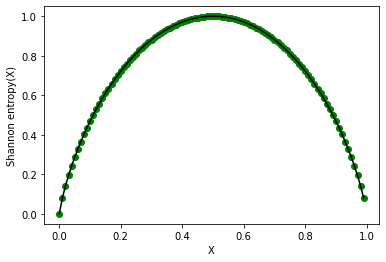

In [40]:
def shannon_entropy(p):   
    return (-p *np.log2(p) - (1-p)*np.log2(1-p))

base=0.0000000001
x = np.arange(base, 1.0-base, 0.01)


plt.figure(1)
plt.plot(x, shannon_entropy(x), 'go', x, shannon_entropy(x), 'k')
plt.ylabel('Shannon entropy(X)')
plt.xlabel('X')
plt.show()

### Uncertainy is not the same as probability

Notice that when $P(X)$ is 0.5 one is most uncertain and the Shannon entropy is highest (i.e. 1). When $P(X)$ is either 0.0 or 1.0 one is most certain and the Shannon entropy is lowest (i.e. 0)


### Computing Information Gain

$$
Information Gain = entropy(parent) – [average entropy(children)]
$$

Note that since the entropy(parent) doesn't change the child node for which entropy is minimum is, equivalently, the child node for which information gain is maximum.  

Intuitively, low entropy means certainty and high entropy means uncertainty. A high information gain is equivalent to going from uncertainty to certainty.


### Let's Build a Decision Tree by Computing Information Gain

Building a decision tree is a simple algorithm once one understands the concept of entropy and information gain.  

1. Calculate the entropy of every attribute using the data set S, using the Shannon entropy.
2. Split the set S into subsets using the attribute for which entropy is minimum (or, equivalently, information gain is maximum)  
3. Make the decision tree (or sub-tree) root node that attribute.  
4. Recur on subsets using remaining attributes. 

## Bootstrapping, bagging, boosting and aggregating predictions


**Bootstrapping**

In [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is any test or metric that relies on random sampling with replacement. Bootstrapping allows assigning
measures of accuracy (defined in terms of bias, variance, confidence intervals, prediction error or some other such measure) to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling
methods. It falls in the broader class of resampling methods.

**Bagging**

The training algorithm for random forests applies the general technique of [bootstrap aggregating](https://en.wikipedia.org/wiki/Bootstrap_aggregating), or bagging, to tree learners. Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($B$ times) selects a random sample with replacement of the training set and fits trees to these samples 

 For $b = 1, ..., B$ 
 - Sample, with replacement, $B$ training examples from $X, Y$; call these $X_b, Y_b$.
 - Train a decision or regression tree $f_b \quad on \quad X_b, Y_b$.

After training, predictions for unseen samples ${mvar|x'}$ can be made by averaging the predictions from all the individual regression trees on ${mvar|x'}$ 

 $$\hat{f} = \frac{1}{B} \sum_{b=1}^Bf_b (x')$$

or by taking the majority vote in the case of decision trees.

This bootstrapping procedure leads to better model performance because it decreases the [Bias–variance dilemma](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

The number of samples/trees, $B$, is a free parameter. Typically, a few hundred to several thousand trees are used, depending on the size and nature of the training set. An optimal number of trees $B$ can be found using cross-validation, or by observing the _out-of-bag error_ the mean prediction error on each training sample $x_i$, using only the trees that did not have $x_i$ in their bootstrap sample. The training and test error tend to level off after some number of trees have been fit.


**Boosting**

[Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning) is an ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weaker learners to strong ones. While boosting is not algorithmically constrained, most boosting algorithms consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are typically weighted in some way that is usually related to the weak learners' accuracy.  After a weak learner is added, the data weights are readjusted, known as "re-weighting".  Misclassified input data gain a higher weight and examples that are classified correctly lose weight. Thus, future weak learners focus more on the examples that previous weak learners misclassified.

There are many boosting algorithms. The many differnce between boosting based decision-tree ensemble methods like XGboost and GBMs is the boosting algorithm used. 


**aggregating predictions**


For regression aggregating predictions can as simple as averaging the predictions from a set of models.  For classification, aggregating predictions can as simple as ataking the majority vote of the predictions from a set of models. 

Usually a surrogate model is used.  Since the output from the models is always predictions, that set of predictions can serve as the input to another algorithm, usually GLMs or tree-based algorithms, which then predict the same target as the base models.  The helps as it, in effect, weights the predictions for each model according to their accuracy rather than weighting them equally as simple averaging or majority vote would do.

_Distributed Random Forest (DRF)_    

A Distributed Random Forest (DRF) is a powerful low-bias classification and regression tool that can fit highly non-linear data. To prevent overfitting a DRF generates a forest of classification or regression trees, rather than a single classification or regression tree through a process called bagging. The variance of estimates can be adjusted by the number of trees used. 

[Random forests](https://en.wikipedia.org/wiki/Random_forest) or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly (B times) selects a random sample with replacement of the training set and fits trees to these samples:

For $b = 1, ..., B$:   

*  Sample, with replacement, B training examples from $X, Y$; call these $X_b, Y_b$.   
*  Train a decision or regression tree $f_b on X_b, Y_b$.  
*  After training, predictions for unseen samples $x'$ can be made by averaging the predictions from all the individual regression trees on $x'$:  

$$
\hat{f} = \frac{1}{B} \sum_{b=1}^Bf_b (x')
$$

or by taking the majority vote in the case of decision trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

The number of samples/trees, $B$, is a free parameter. Typically, a few hundred to several thousand trees are used, depending on the size and nature of the training set. An optimal number of trees $B$ can be found using cross-validation, or by observing the out-of-bag error: the mean prediction error on each training sample $x_i$, using only the trees that did not have $x_i$ in their bootstrap sample. The training and test error tend to level off after some number of trees have been fit.


_Extreme Random Forest (XRT)_

Extreme random forests are nearly identical to standard random forests except that the splits, both attribute and cut-point, are chosen totally or partially at random. Bias/variance
analysis has shown that XRTs work by decreasing variance while at the same time increasing bias. Once the randomization level is properly adjusted, the variance almost vanishes while bias only slightly increases with respect to standard trees. 


_Gradient Boosting Machine (GBM)_   

Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. Boosting can create more accurate models than bagging but doesn’t help to avoid overfitting as much as bagging does.

Unlike a DRF which uses bagging to prevent overfitting a GBM uses boosting to sequentially refine a regression or classification tree. However as each tree is built in parallel it allows for multi-threading (asynchronous) training large data sets.

As with all tree based methods it creates decision trees and is highly interpretable.


_XGBoost_

XGBoost is a supervised learning algorithm that implements a process called boosting to yield accurate models. Boosting refers to the ensemble learning technique of building many models sequentially, with each new model attempting to correct for the deficiencies in the previous model. 

Both XGBoost and GBM follows the principle of gradient boosting. However, XGBoost has a more regularized model formalization to control overfitting. Boosting does not prevent overfitting the way bagging does, but typically gives better accuracy. XGBoost corrects for the deficiencies of boosting by ensembling regularized trees.

Like a GBM, each tree is built in parallel it allows for multi-threading (asynchronous) training large data sets.

As with all tree based methods it creates decision trees and is highly interpretable.

**Preventing overfitting**

The idea of overfitting means that your prediction model is too biased towards your training data. To limit overfitting two things are usually done:

  * Limit the tree size (see above)    
  * Prune the decision trees (see below) 
  
_Constraints on Tree Size_  

When creating a decision tree, there is a trade-off between its simplicity and predictive power. A deep tree with many leaves is usually over-fitting the training data. In contrast, a shallow tree may not have high training accuracy. 

One wants a tree that is deep enough to be accurate on the training data while being shallow enough to be predictive on a wide range of data. As a rule of thumb, a depth of the square root of the total number of features should be in the ballpark but we should always check the tree through cross-validatiion and how sensible the rules generated are.

**Pruning**  

The [pruning](https://en.wikipedia.org/wiki/Pruning_(decision_trees)) (of a node) in a decision tree, reduces the size of decision trees by removing sections of the tree that provide little power to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.

Pruning can occur in a top down or bottom up fashion. A top down pruning will traverse nodes and trim subtrees starting at the root, while a bottom up pruning will start at the leaf nodes. Below are several popular pruning algorithms.

_Reduced error pruning_    

One of the simplest forms of pruning is reduced error pruning. Starting at the leaves, each node is replaced with its most popular class. If the prediction accuracy is not affected then the change is kept. While somewhat naive, reduced error pruning has the advantage of simplicity and speed.

_Cost complexity pruning_  

Cost complexity pruning generates a series of trees $T_0 . . . T_m$ where $T_0$ is the initial tree and $T_m$ is the root alone. At step $i$ the tree is created by removing a subtree from tree $i-1$ and replacing it with a leaf node with value chosen as in the tree building algorithm. The subtree that is removed is chosen as follows. Define the error rate of tree $T$ over data set $S$ as $err(T,S)$. The subtree that minimizes 

$$\frac{err(prune(T,t),S)-err(T,S)}{|leaves(T)|-|leaves(prune(T,t))|}$$

is chosen for removal. The function prune(T,t) defines the tree gotten by pruning the subtrees t from the tree T. Once the series of trees has been created, the best tree is chosen by generalized accuracy as measured by a training set or cross-validation.


**Decision Trees Pros and Cons**  

_Advantages_  

Easy to Understand: Decision tree output is very easy to interpret. One can often check the rules to see if they make sense.

Significant Variables: Decision tree is one of the fastest way to identify most significant variables and relation between two or more variables. 

Non Parametric: Decision treea are usually created with non-parametric algorithms. Non-parametric models do not require the modeler to make any assumptions about the distribution of the population, and so are sometimes referred to as a distribution-free method. 

_Disadvantages_   

Over fitting: Over fitting is easy with decision trees. Limiting the tree depth, cross-validation and pruning are essential to creating robust trees. 




### Appendix - Entropy and information gain

#### Plog

Plog (which we pronounce ‘plog, ’ for positive log) is simply the negative log of the frequency. As the value of plog increases, the frequency decreases. 

$$
E(X) = -\sum\ln{p_i}
$$



freq  | (base 2)  
----  | -------------  
0.5   |  1  
0.25  |  2  
1/16  |  5  

  

Big plog means low frequency.

#### Rényi entropies  

The [Rényi entropies](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy) generalize the Shannon entropy, the Hartley entropy, the min-entropy, and the collision entropy. As such, these entropies as an ensemble are often called the Rényi entropies (or the Rényi entropy, even though this usually refers to a class of entropies). The difference between these entropies is in the respective value for each of an order parameter called alpha: the values of alpha are greater than or equal to zero but cannot equal one. The Renyi entropy ordering is related to the underlying probability distributions and allows more probable events to be weighted more heavily. As alpha approaches zero, the Rényi entropy increasingly weighs all possible events more equally, regardless of their probabilities. A higher alpha (a) weighs more probable events more heavily. The base used to calculate entropies is usually base 2 or Euler's number base $e$. If the base of the logarithm is 2, then the uncertainty is measured in bits. If it is the natural logarithm, then the unit is nats. 

#### Rényi entropies	 

The Rényi entropy of order $\alpha$, where $\alpha \geq 0$  and $\alpha \neq 1$ , is defined as

$$
H_\alpha(X) = \frac{1}{1-\alpha}\log\Bigg(\sum_{i=1}^n p_i^\alpha\Bigg)
$$

Here, X is a discrete random variable with possible outcomes 1,2,...,n and corresponding probabilities $p_i \doteq \Pr(X=i) for i=1,\dots,n,$ and the logarithm is base 2. 


#### Hartley entropy

The Hartley entropy is the Rényi entropy with an alpha of zero. 

the probabilities are nonzero, $H_0$ is the logarithm of the cardinality of X, sometimes called the Hartley entropy of X:  

$$
H_0 (X) = \log n = \log |X|
$$

#### Shannon entropy 

The Shannon entropy is the Rényi entropy with an alpha of one. The Shannon entropy is a simple estimate of the expected value of the information contained in a message. It assumes independence and identically distributed random variables, which is a simplification when applied to word counts. In this sense it is analogous to naïve Bayes, in that it is very commonly used and thought to work well in spite of violating some assumptions upon which it is based.

The limiting value of $H_\alpha as \alpha \rightarrow 1$ is the Shannon entropy:

$$
H_1 (X) = - \sum_{i=1}^n p_i \log p_i. 
$$

#### collision entropy

The collision entropy is the Rényi entropy with an alpha of two and is sometimes just called "Rényi entropy," refers to the case $\alpha = 2$,

$$
H_2 (X) = - \log \sum_{i=1}^n p_i^2 = - \log P(X = Y)
$$

where $X$ and $Y$ are independent and identically distributed. 

#### min-entropy

The min-entropy is the Rényi entropy as the limit of alpha approaches infinity. The name min-entropy stems from the fact that it is the smallest entropy measure in the Rényi family of entropies. In the limit as $\alpha \rightarrow \infty$, the Rényi entropy $H_\alpha converges to the min-entropy H_\infty$:

$$
H_\infty(X) \doteq \min_i (-\log p_i) = -(\max_i \log p_i) = -\log \max_i p_i\,.
$$

Equivalently, the min-entropy $H_\infty(X)$ is the largest real number b such that all events occur with probability at most $2^{-b}$.


#### Kullback-Leibler divergence

[Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is a non-symmetric measure of the difference between two probability distributions. The Kullback-Leibler measure goes by several names: relative entropy, discrimination information, Kullback-Leibler (KL) number, directed divergence, informational divergence, and cross entropy. Kullback-Leibler divergence is a measure of the difference between the observed entropy and its excepted entropy. We calculate the KL divergence by weighting one distribution (like an observed frequency distribution) by the log of probabilities of some other distribution D2. For discrete probability distributions P and Q, the Kullback–Leibler divergence of Q from P is defined to be

$$
D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \ln\frac{P(i)}{Q(i)}
$$

In words, it is the expectation of the logarithmic difference between the probabilities P and Q, where the expectation is taken using the probabilities P.


#### Mutual Information

[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) quantifies the mutual dependence of the two random variables. It is a measure of the “stickiness” between two items. It measures how much knowing one of these variables reduces uncertainty about the other. We can use mutual information to quantify the association between two tags. Mutual information is given by:

the mutual information of two discrete random variables X and Y can be defined as:

$$
 I(X;Y) = \sum_{y \in Y} \sum_{x \in X} 
                 p(x,y) \log{ \left(\frac{p(x,y)}{p(x)\,p(y)}
                              \right) }, \,\!
$$                              
                              
where $p(x,y)$ is the joint probability distribution function of $X$ and $Y$, and $p(x)$ and $p(y)$ are the marginal probability distribution functions of $X$ and $Y$ respectively. In the case of continuous random variables, the summation is replaced by a definite double integral:

$$
 I(X;Y) = \int_Y \int_X 
                 p(x,y) \log{ \left(\frac{p(x,y)}{p(x)\,p(y)}
                              \right) } \; dx \,dy,
$$
 
where $p(x,y)$ is now the joint probability density function of $X$ and $Y$, and $p(x$) and $p(y)$ are the marginal probability density functions of $X$ and $Y$ respectively.

#### Gini Index

The [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) (sometimes expressed as a Gini ratio or a normalized Gini index) is a measure of homogeneity. A Gini coefficient (G) of zero expresses perfect equality, where all values are the same. A Gini coefficient of 1 (or 100%) expresses maximal inequality among values. G is a measure of inequality, defined as the mean of absolute differences between all pairs of individuals for some measure.


#### Chi-Square

A [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test), also written as $\chi^2$ test, is any statistical hypothesis test wherein the sampling distribution of the test statistic is a chi-squared distribution when the null hypothesis is true. It is used to test the statistical significance between the differences between sub-nodes and parent node. 

We measure it by sum of squares of standardized differences between observed and expected frequencies of sample population. Chi-squared tests are often constructed from a sum of squared errors, or through the sample variance. Test statistics that follow a chi-squared distribution arise from an assumption of independent normally distributed data. A chi-squared test can be used to attempt rejection of the null hypothesis that the data are independent.

The higher the value of Chi-Square, the higher the statistical significance of differences between two populations.

Chi-Square of each node is calculated using formula and the observed, $O$, and expected, $E$, frequencies of sample population.

$$
\tilde{\chi}^2=\frac{1}{d}\sum_{k=1}^{n} \frac{(O_k - E_k)^2}{E_k}\
$$

#### Reduction in Variance


Reduction in variance is often used to calculate information gain when one has continuous variables rather than categorical variables.

The variance reduction of a node $N$ is defined as the total reduction of the variance of the target variable $x$ due to the split at this node:

$$
I_{V}(N) = \frac{1}{|S|^2}\sum_{i\in S} \sum_{j\in S} \frac{1}{2}(x_i - x_j)^2 - \left(\frac{1}{|S_t|^2}\sum_{i\in S_t} \sum_{j\in S_t} \frac{1}{2}(x_i - x_j)^2 + \frac{1}{|S_f|^2}\sum_{i\in S_f} \sum_{j\in S_f} \frac{1}{2}(x_i - x_j)^2\right)
$$

where $S$, $S_t$, and $S_f$ are the set of presplit sample indices, set of sample indices for which the split test is true, and set of sample indices for which the split test is false, respectively. Each of the above summands are indeed [variance](https://en.wikipedia.org/wiki/Variance) estimates, though, written in a form without directly referring to the mean.

#### ID3 algorithm

This idea of iteratively finding the attribute with the most information gain to find a root in decision tree learning is called the  [ID3 (Iterative Dichotomiser 3)](https://en.wikipedia.org/wiki/ID3_algorithm) algorithm. The invented by [Ross Quinlan](https://en.wikipedia.org/wiki/Ross_Quinlan). It is a simple algorithm once one understands the concept of entropy and information gain.  

1.  Calculate the entropy of every attribute using the data set S, using the Shannon entropy.
2. Split the set S into subsets using the attribute for which entropy is minimum (or, equivalently, information gain is maximum)  
3. Make the decision tree (or sub-tree) root node that attribute.  
4. Recur on subsets using remaining attributes.  

#### C4.5 algorithm

[C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm) is an extension of Quinlan's earlier ID3 algorithm. The splitting criterion is based on statistical confidence estimates. This technique has the advantage that it allows all of the available labeled data to be used for training. To generate this confidence one calculates the error rate over $n$ labled training instances. The observed error rate $e$ is analaogous to the observed fraction of heads in $n$  tosses of a biased coin (i.e. the probability of heads may not be 0.5). One wishes to estimate the true error rate, $p$ from the observed error rate $e$.   

The confidence interval, is calculated as follows, if one chooses a level of confidence $z$ then 

$$
p = e + z \times \sqrt{e \times \frac{1-e}{n}}
$$  

Paired values for z and confidence levels (z,confidence) are in the following lists: (0.67 z, 50% confidence), (1.0 z, 68% confidence) , (1.64 z, 90% confidence) and (1.96 z, 95% confidence).



Copyright 2019 NEU AI Skunkworks

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.